In [1]:
from datasets import load_dataset

dataset = load_dataset("seyonec/goodscents_leffingwell")

/anaconda/envs/dgllife/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration seyonec--goodscents_leffingwell-6c3ff2855cfd27cf
Found cached dataset json (/home/t-seyonec/.cache/huggingface/datasets/seyonec___json/seyonec--goodscents_leffingwell-6c3ff2855cfd27cf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
100%|██████████| 3/3 [00:00<00:00, 803.87it/s]


In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 4689
    })
    test: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 587
    })
    validation: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 586
    })
})

In [3]:
type(dataset['train']['y'][3])

list

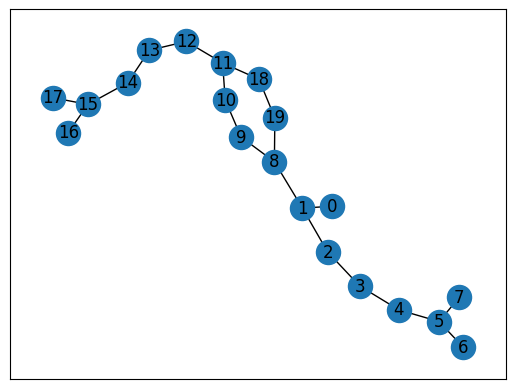

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# We want to plot the first train graph
graph = dataset["train"][0]

edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

# Conversion to networkx format
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

# Plot
nx.draw_networkx(G)



In [4]:
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

dataset_processed = dataset.map(preprocess_item, batched=False)



Loading cached processed dataset at /home/t-seyonec/.cache/huggingface/datasets/seyonec___json/seyonec--goodscents_leffingwell-6c3ff2855cfd27cf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-bb420f82f0ea412d.arrow
Loading cached processed dataset at /home/t-seyonec/.cache/huggingface/datasets/seyonec___json/seyonec--goodscents_leffingwell-6c3ff2855cfd27cf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-e32d18902e3474f2.arrow
Loading cached processed dataset at /home/t-seyonec/.cache/huggingface/datasets/seyonec___json/seyonec--goodscents_leffingwell-6c3ff2855cfd27cf/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-28b33dc34816efd4.arrow


In [5]:
dataset_processed['train']['y'][0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [6]:
from transformers import GraphormerForGraphClassification

model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    num_classes=152, # num_classes for the downstream task 
    ignore_mismatched_sizes=True,
)



Some weights of GraphormerForGraphClassification were not initialized from the model checkpoint at clefourrier/pcqm4mv2_graphormer_base and are newly initialized because the shapes did not match:
- classifier.classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([152, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    "graph-classification",
    logging_dir="gs_lf_graphormer",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    auto_find_batch_size=True, # batch size can be changed automatically to prevent OOMs
    gradient_accumulation_steps=10,
    dataloader_num_workers=4, #1, 
    num_train_epochs=20,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    push_to_hub=False,
)



In [8]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_processed["train"],
    eval_dataset=dataset_processed["validation"],
    data_collator=GraphormerDataCollator(),
)



In [9]:
train_results = trainer.train()

/anaconda/envs/dgllife/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/anaconda/envs/dgllife/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/anaconda/envs/dgllife/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/anaconda/envs/dgllife/lib/python3.8/site-packages/transformers/models/graphormer/collating_graphormer.py", line 119, in __call__
    batch["input_edges"][
RuntimeError: The expanded size of the tensor (3) must match the existing size (0) at non-singleton dimension 3.  Target sizes: [1, 1, 0, 3].  Tensor sizes: [0]


In [24]:
import transformers

print(transformers.__version__)

4.31.0
